<h2>Importing Libraries</h2>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Only one import
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from sklearn.metrics import confusion_matrix, average_precision_score
#from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
#from selenium.webdriver.common.by import By
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
import glob
import warnings
import os
import time
import requests
warnings.simplefilter(action='ignore', category=FutureWarning)

<h2>Checking For GPU Availability</h2>

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


<h2>Data Preparation and Loading</h2>

In [ ]:
# Search images in gettyimages with Selenium
class_names = ["tundra-wolf","domestic-dog","italian-wolf","arctic-wolf","red-wolf"]
site = ["https://www.gettyimages.com/search/2/image-film?family=creative&phrase=tundra%20wolf",
      "https://www.gettyimages.com/search/2/image?phrase=domestic%20dog&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=italian%20wolf&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=arctic%20wolf&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=red%20wolf"]

os.chdir("C:/Users/Admin/Python/Mini/Wolf-Subspecies/datasets")# Move directory to download file there

cService = webdriver.ChromeService(executable_path='C:/Users/Admin/Downloads/chromedriver/chromedriver.exe')# Chromedriver path

# Creating a webdriver instance
driver = webdriver.Chrome(service = cService)

# Maximize the screen
driver.maximize_window()

for i in range(0,5):
    # Open url in the browser
    driver.get(site[i])
    # for image naming index
    index = 0

    # Going through 10 pages, as each page contains 60 images
    for p in range(0,10):
        # Class name and src of each image
        img_tag = driver.find_elements(By.CLASS_NAME,'Xc8V0Fvh0qg0lUySLpoi')
        img_url = [img.get_attribute('src') for img in img_tag if 'media.gettyimages' in img.get_attribute('src')]

        # download images
        for a, urls in enumerate(img_url[:60]):
            response = requests.get(urls, stream=True)
            index += 1
            with open(f'{class_names[i]} {index}.jpg','wb') as f:
                for chunk in response.iter_content(chunk_size=128):
                  f.write(chunk)

        try:# click on "Next" button to go to the next page
            driver.find_element(By.LINK_TEXT,'NEXT').click()

            # waiting for the results to load
            # Increase the sleep time if your internet is slow
            time.sleep(3)

        except:
            pass

# Finally, we close the driver
driver.close()

In [ ]:
for classes in class_names:
    if os.path.isdir('train/'+classes) is False:
        os.makedirs('train/'+classes)
        os.makedirs('valid/'+classes)
        os.makedirs('test/'+classes)

        for c in random.sample(glob.glob(classes+'*.jpg'),420):
            shutil.move(c, 'train/'+classes)
        for c in random.sample(glob.glob(classes+'*.jpg'),120):
            shutil.move(c, 'valid/'+classes)
        for c in random.sample(glob.glob(classes+'*.jpg'),60):
            shutil.move(c,'test/'+classes)

os.chdir('../../')

<h2>Continue in Google Colab</h2>

In [ ]:
!apt-get install p7zip-full
!7z x /content/Wolf-Subspecies.zip -o/content/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 122071474 bytes (117 MiB)

Extracting archive: /content/Wolf-Subspecies.zip
--
Path = /content/Wolf-Subspecies.zip
Type = zip
Physical Size = 122071474

  0%      9% 273         17% 527 - Wolf-Subspecies/datasets/train/arctic-wolf/arctic-wolf 391.jpg                                                                         

In [ ]:
train_path = '/content/Wolf-Subspecies/datasets/train'
valid_path = '/content/Wolf-Subspecies/datasets/valid'
test_path = '/content/Wolf-Subspecies/datasets/test'

<h3>Plot Confusion Matrix Function</h3>

In [ ]:
import itertools
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<h1>ResNet50</h1>

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

valid_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

test_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32,
        shuffle=False
    )

Found 2100 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [ ]:
assert train_batches_resnet50.n == 2100
assert valid_batches_resnet50.n == 600
assert test_batches_resnet50.n == 300
assert train_batches_resnet50.num_classes == valid_batches_resnet50.num_classes == test_batches_resnet50.num_classes == 5

In [ ]:
imgs_resnet50 , labels_resnet50 = next(train_batches_resnet50)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

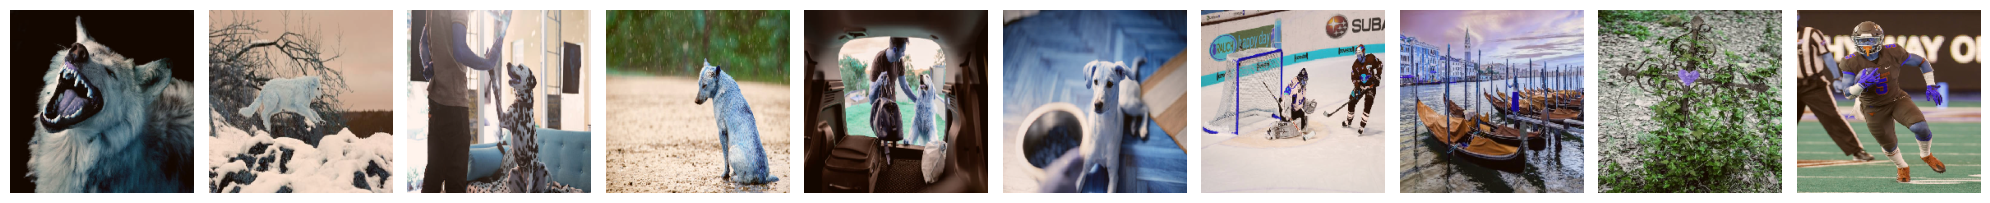

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
plotImages(imgs_resnet50)
print(labels_resnet50)

<h2>Training Model: ResNet50</h2>

In [ ]:
# ResNet50 Model
resnet50_model = ResNet50(weights=None, input_shape=(224,224,3), classes=len(train_batches_resnet50.class_indices))

In [ ]:
resnet50_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_resnet50 = time.time()

In [ ]:
history_resnet50 = resnet50_model.fit(x=train_batches_resnet50, validation_data=valid_batches_resnet50, epochs=50, verbose=2)
training_time_resnet50 = time.time() - start_time_resnet50

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 123s - 2s/step - accuracy: 0.3848 - loss: 1.5318 - val_accuracy: 0.2050 - val_loss: 2.6583
Epoch 2/50
66/66 - 78s - 1s/step - accuracy: 0.4762 - loss: 1.3251 - val_accuracy: 0.2367 - val_loss: 4.0068
Epoch 3/50
66/66 - 42s - 634ms/step - accuracy: 0.4948 - loss: 1.2686 - val_accuracy: 0.2000 - val_loss: 5.7855
Epoch 4/50
66/66 - 40s - 611ms/step - accuracy: 0.5319 - loss: 1.1889 - val_accuracy: 0.2000 - val_loss: 5.3569
Epoch 5/50
66/66 - 25s - 372ms/step - accuracy: 0.5524 - loss: 1.1408 - val_accuracy: 0.2317 - val_loss: 3.5569
Epoch 6/50
66/66 - 40s - 605ms/step - accuracy: 0.5871 - loss: 1.0725 - val_accuracy: 0.3050 - val_loss: 2.2233
Epoch 7/50
66/66 - 25s - 381ms/step - accuracy: 0.5914 - loss: 1.0522 - val_accuracy: 0.4517 - val_loss: 1.3495
Epoch 8/50
66/66 - 39s - 593ms/step - accuracy: 0.6338 - loss: 0.9843 - val_accuracy: 0.5400 - val_loss: 1.2719
Epoch 9/50
66/66 - 44s - 660ms/step - accuracy: 0.6371 - loss: 0.9567 - val_accuracy: 0.4683 - val_loss: 1.4379
Epoch 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

resnet50_model.save('/content/drive/MyDrive/resnet50_model.h5')
print("ResNet50 model saved to Google Drive!")

Mounted at /content/drive
ResNet50 model saved to Google Drive!


In [ ]:
resnet50_model.save('/content/drive/MyDrive/resnet50_model.keras')
print("ResNet50 model saved to Google Drive in Keras format!")

ResNet50 model saved to Google Drive in Keras format!


<h2>Model Accuracy: ResNet50 </h2>

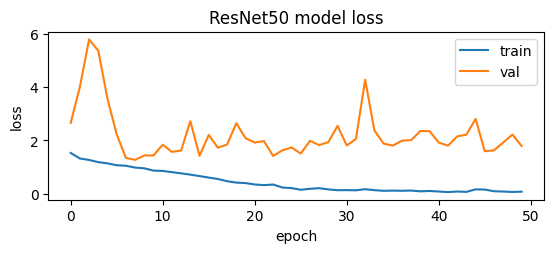

In [ ]:
plt.subplot(2,1,2)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

<h2>Training Loss: ResNet50</h2>

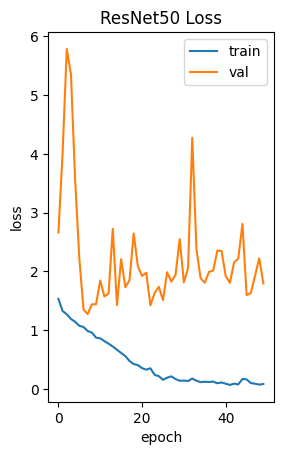

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Train')
plt.plot(history_resnet50.history['val_loss'], label='Validation')
plt.title('ResNet50 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

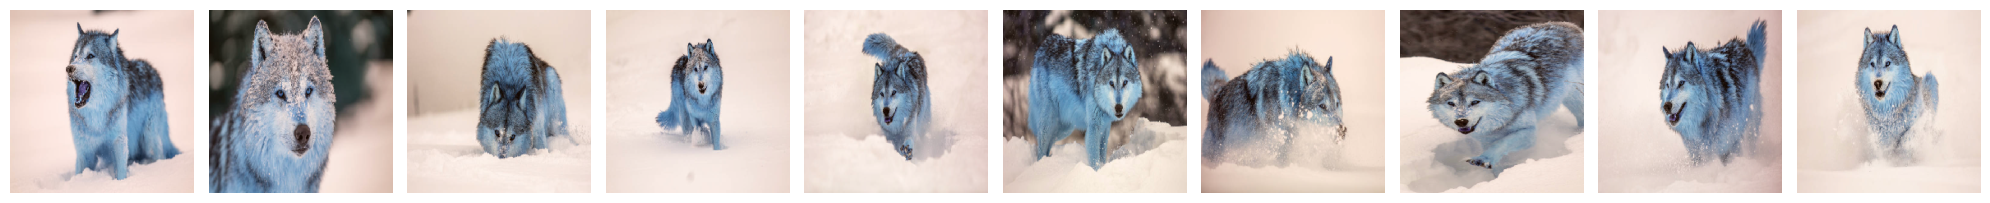

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
test_imgs_resnet50, test_labels_resnet50 = next(test_batches_resnet50)
plotImages(test_imgs_resnet50)
print(test_labels_resnet50)

In [ ]:
test_batches_resnet50.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], d

In [ ]:
predictions_resnet50 = resnet50_model.predict(x=test_batches_resnet50, verbose=0)

In [ ]:
np.round(predictions_resnet50)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
cm_resnet50 = confusion_matrix(y_true=test_batches_resnet50.classes, y_pred=np.argmax(predictions_resnet50, axis=-1))

In [ ]:
test_batches_resnet50.class_indices


{'tundra-wolf': 0,
 'domestic-dog': 1,
 'italian-wolf': 2,
 'arctic-wolf': 3,
 'red-wolf': 4}

Confusion matrix, without normalization
[[37  0  5 14  4]
 [ 2 32  8  9  9]
 [ 2  1 39 10  8]
 [10  1  4 39  6]
 [ 1  1 10  7 41]]


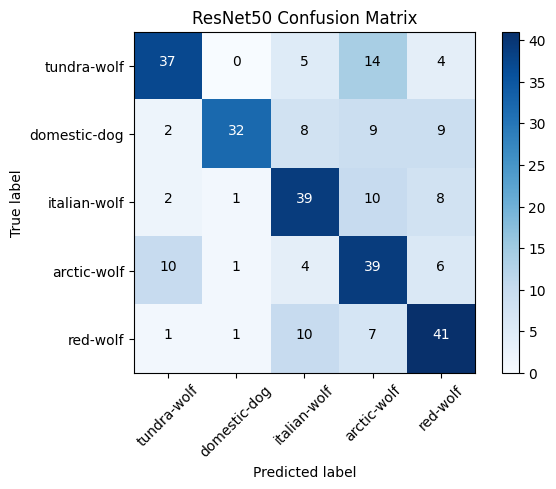

In [ ]:
cm_plot_labels_resnet50 = ['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf']
plot_confusion_matrix(cm=cm_resnet50, classes=cm_plot_labels_resnet50, title='ResNet50 Confusion Matrix')

In [ ]:
loss_resnet50, acc_resnet50 = resnet50_model.evaluate(test_imgs_resnet50, test_labels_resnet50, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7500 - loss: 0.9312


In [ ]:
print("Training time using ResNet50 model: " + str(training_time_resnet50 / 60) + " minute")

Training time using ResNet50 model: 28.502131112416585 minute


In [3]:
# Confusion matrix
confusion_matrix = np.array([
    [37,  0,  5, 14,  4],  # tundra-wolf
    [ 2, 32,  8,  9,  9],  # domestic-dog
    [ 2,  1, 39, 10,  8],  # italian-wolf
    [10,  1,  4, 39,  6],  # arctic-wolf
    [ 1,  1, 10,  7, 41]   # red-wolf
])

# Number of classes
num_classes = confusion_matrix.shape[0]

# Initialize lists to store Precision, Recall, and F1-score for each class
precisions = []
recalls = []
f1_scores = []

# Calculate metrics for each class
for i in range(num_classes):
    TP = confusion_matrix[i, i]  # True Positives
    FP = np.sum(confusion_matrix[:, i]) - TP  # False Positives
    FN = np.sum(confusion_matrix[i, :]) - TP  # False Negatives

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1-score (AP for the class)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Append to lists
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Calculate mean Average Precision (mAP)
mAP = np.mean(f1_scores)

# Print results
print("Class-wise Precision:", precisions)
print("Class-wise Recall:", recalls)
print("Class-wise F1-scores (AP):", f1_scores)
print("Mean Average Precision (mAP):", mAP)

Class-wise Precision: [0.7115384615384616, 0.9142857142857143, 0.5909090909090909, 0.4936708860759494, 0.6029411764705882]
Class-wise Recall: [0.6166666666666667, 0.5333333333333333, 0.65, 0.65, 0.6833333333333333]
Class-wise F1-scores (AP): [0.6607142857142857, 0.6736842105263158, 0.6190476190476191, 0.5611510791366907, 0.640625]
Mean Average Precision (mAP): 0.6310444388849822


<h1>DenseNet121</h1>

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

train_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

valid_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

test_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32,
        shuffle=False
    )

Found 2100 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [ ]:
assert train_batches_densenet121.n == 2100
assert valid_batches_densenet121.n == 600
assert test_batches_densenet121.n == 300
assert train_batches_densenet121.num_classes == valid_batches_densenet121.num_classes == test_batches_densenet121.num_classes == 5


In [ ]:
imgs_densenet121 , labels_densenet121 = next(train_batches_densenet121)

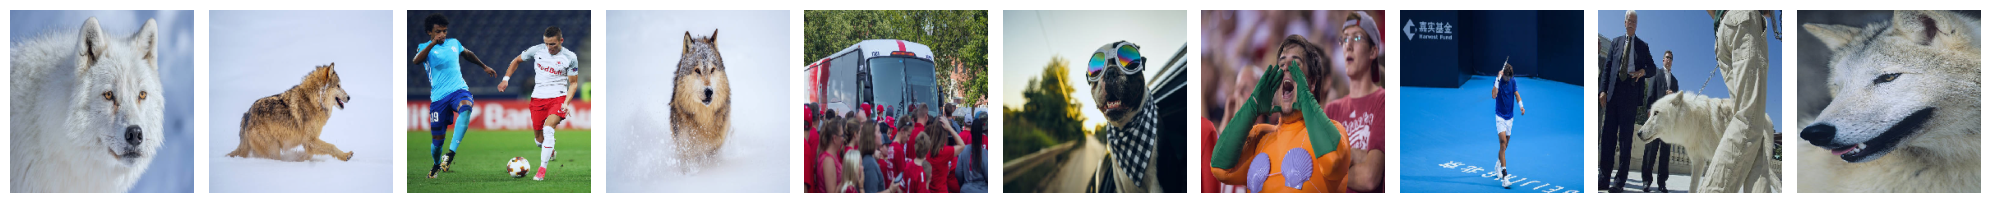

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
plotImages(imgs_densenet121)
print(labels_densenet121)

<h2>Training Model: DenseNet121</h2>

In [ ]:
# DenseNet121 Model
densenet121_model = DenseNet121(weights=None, input_shape=(224,224,3), classes=len(train_batches_densenet121.class_indices))

In [ ]:
densenet121_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
densenet121_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_densenet121 = time.time()

In [ ]:
history_densenet121 = densenet121_model.fit(x=train_batches_densenet121, validation_data=valid_batches_densenet121, epochs=50, verbose=2)
training_time_densenet121 = time.time() - start_time_densenet121

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 323s - 5s/step - accuracy: 0.4881 - loss: 1.2596 - val_accuracy: 0.2467 - val_loss: 1.7690
Epoch 2/50
66/66 - 25s - 383ms/step - accuracy: 0.5900 - loss: 1.0510 - val_accuracy: 0.2000 - val_loss: 2.1841
Epoch 3/50
66/66 - 41s - 623ms/step - accuracy: 0.6362 - loss: 0.9204 - val_accuracy: 0.2417 - val_loss: 2.2141
Epoch 4/50
66/66 - 41s - 616ms/step - accuracy: 0.6757 - loss: 0.8414 - val_accuracy: 0.3017 - val_loss: 2.0418
Epoch 5/50
66/66 - 42s - 631ms/step - accuracy: 0.7090 - loss: 0.7549 - val_accuracy: 0.4967 - val_loss: 1.5121
Epoch 6/50
66/66 - 41s - 614ms/step - accuracy: 0.7386 - loss: 0.6860 - val_accuracy: 0.5883 - val_loss: 1.1359
Epoch 7/50
66/66 - 40s - 609ms/step - accuracy: 0.7733 - loss: 0.6248 - val_accuracy: 0.6367 - val_loss: 1.0466
Epoch 8/50
66/66 - 25s - 372ms/step - accuracy: 0.8067 - loss: 0.5251 - val_accuracy: 0.6417 - val_loss: 1.0612
Epoch 9/50
66/66 - 24s - 364ms/step - accuracy: 0.8186 - loss: 0.4921 - val_accuracy: 0.6900 - val_loss: 1.0068
Epoch

In [ ]:
# Or save it to Google Drive
densenet121_model.save('/content/drive/MyDrive/densenet121_model.h5')
print("DenseNet121 model saved to Google Drive!")

densenet121_model.save('/content/drive/MyDrive/densenet121_model.keras')
print("DenseNet121 model saved to Google Drive in Keras format!")

DenseNet121 model saved to Google Drive!
DenseNet121 model saved to Google Drive in Keras format!


<h2>Model Accuracy: DenseNet121</h2>

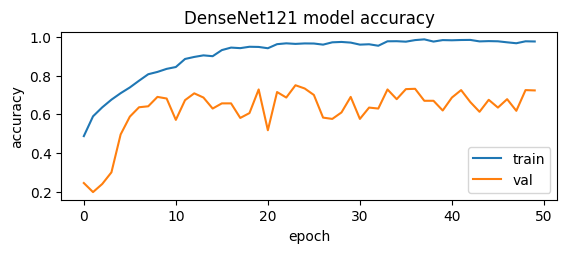

In [ ]:
plt.subplot(2,1,1)
plt.plot(history_densenet121.history['accuracy'])
plt.plot(history_densenet121.history['val_accuracy'])
plt.title('DenseNet121 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: DenseNet121</h2>

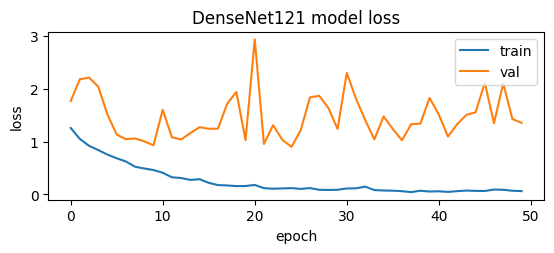

In [ ]:
plt.subplot(2,1,2)
plt.plot(history_densenet121.history['loss'])
plt.plot(history_densenet121.history['val_loss'])
plt.title('DenseNet121 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

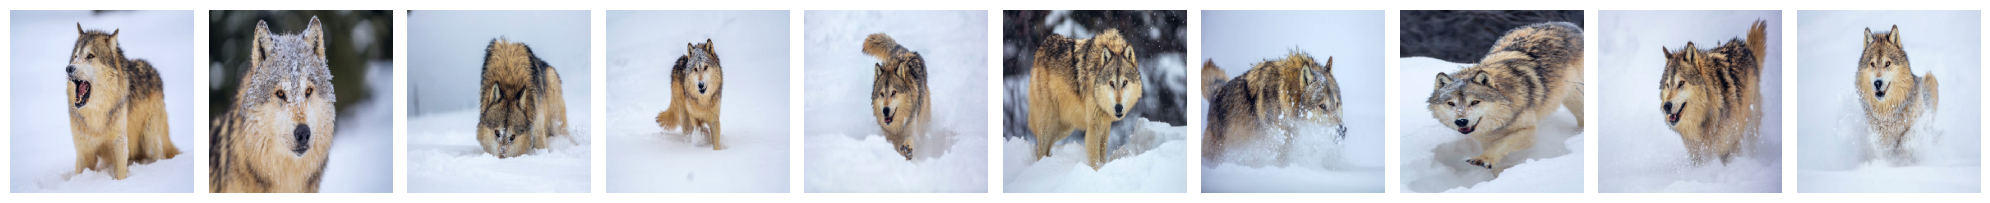

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
test_imgs_densenet121, test_labels_densenet121 = next(test_batches_densenet121)
plotImages(test_imgs_densenet121)
print(test_labels_densenet121)

In [ ]:
test_batches_densenet121.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], d

In [ ]:
predictions_densenet121 = densenet121_model.predict(x=test_batches_densenet121, verbose=0)

In [ ]:
np.round(predictions_densenet121)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
cm_densenet121 = confusion_matrix(y_true=test_batches_densenet121.classes, y_pred=np.argmax(predictions_densenet121, axis=-1))

In [ ]:
test_batches_densenet121.class_indices

{'tundra-wolf': 0,
 'domestic-dog': 1,
 'italian-wolf': 2,
 'arctic-wolf': 3,
 'red-wolf': 4}

Confusion matrix, without normalization
[[45  1  4  9  1]
 [ 1 52  2  0  5]
 [ 1  9 36  5  9]
 [16  4  3 29  8]
 [ 4  6  5  1 44]]


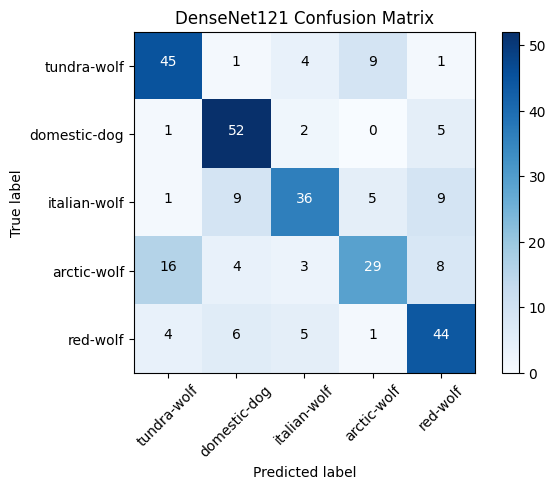

In [ ]:
cm_plot_labels_densenet121 = ['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf']
plot_confusion_matrix(cm=cm_densenet121, classes=cm_plot_labels_densenet121, title='DenseNet121 Confusion Matrix')

In [ ]:
loss_densenet121, acc_densenet121 = densenet121_model.evaluate(test_imgs_densenet121, test_labels_densenet121, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8750 - loss: 0.2970


In [ ]:
print("Training time using DenseNet121 model: " + str(training_time_densenet121 / 60) + " minute")

Training time using DenseNet121 model: 32.15948719183604 minute


In [4]:
# Confusion matrix
confusion_matrix = np.array([
    [45, 1, 4, 9, 1],  # Tundra-wolf
    [1, 52, 2, 0, 5],  # Domestic-dog
    [1, 9, 36, 5, 9],  # Italian-wolf
    [16, 4, 3, 29, 8],  # Arctic-wolf
    [4, 6, 5, 1, 44]   # Red-wolf
])

# Number of classes
num_classes = confusion_matrix.shape[0]

# Initialize lists to store precision, recall, and AP for each class
precisions = []
recalls = []
average_precisions = []

# Calculate precision, recall, and AP for each class
for i in range(num_classes):
    TP = confusion_matrix[i, i]  # True Positives
    FP = np.sum(confusion_matrix[:, i]) - TP  # False Positives
    FN = np.sum(confusion_matrix[i, :]) - TP  # False Negatives

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Store precision and recall
    precisions.append(precision)
    recalls.append(recall)

    # Average Precision (AP) as the average of precision and recall
    AP = (precision + recall) / 2
    average_precisions.append(AP)

# Calculate mean Average Precision (mAP)
mAP = np.mean(average_precisions)

# Print results
print("Class-wise Precision:", precisions)
print("Class-wise Recall:", recalls)
print("Class-wise Average Precision (AP):", average_precisions)
print("Mean Average Precision (mAP):", mAP)

Class-wise Precision: [0.6716417910447762, 0.7222222222222222, 0.72, 0.6590909090909091, 0.6567164179104478]
Class-wise Recall: [0.75, 0.8666666666666667, 0.6, 0.48333333333333334, 0.7333333333333333]
Class-wise Average Precision (AP): [0.710820895522388, 0.7944444444444445, 0.6599999999999999, 0.5712121212121212, 0.6950248756218905]
Mean Average Precision (mAP): 0.6863004673601688


<h1>MobileNetV3</h1>

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess

train_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

valid_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

test_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32,
        shuffle=False
    )

Found 2100 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [ ]:
assert train_batches_mobilenetv3.n == 2100
assert valid_batches_mobilenetv3.n == 600
assert test_batches_mobilenetv3.n == 300
assert train_batches_mobilenetv3.num_classes == valid_batches_mobilenetv3.num_classes == test_batches_mobilenetv3.num_classes == 5


In [ ]:
imgs_mobilenetv3 , labels_mobilenetv3 = next(train_batches_mobilenetv3)

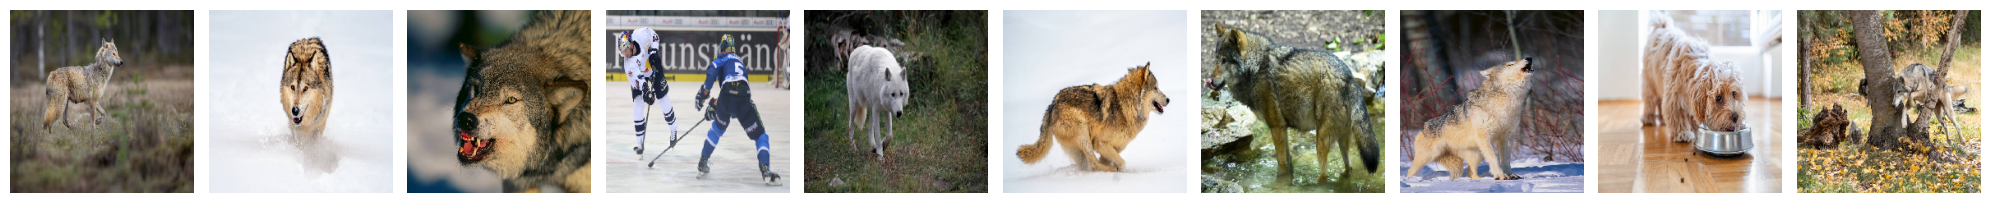

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
plotImages(imgs_mobilenetv3)
print(labels_mobilenetv3)

<h2>Training Model: MobileNetV3</h2>

In [ ]:
# MobileNetV3 Model
mobilenetv3_model = MobileNetV3Small(weights=None, input_shape=(224,224,3), classes=len(train_batches_mobilenetv3.class_indices))

In [ ]:
mobilenetv3_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├──────────────────────

 Total params: 1,535,093 (5.86 MB)

 Trainable params: 1,522,981 (5.81 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
mobilenetv3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_mobilenetv3 = time.time()

In [ ]:
history_mobilenetv3 = mobilenetv3_model.fit(x=train_batches_mobilenetv3, validation_data=valid_batches_mobilenetv3, epochs=50, verbose=2)
training_time_mobilenetv3 = time.time() - start_time_mobilenetv3

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 156s - 2s/step - accuracy: 0.3424 - loss: 1.4917 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 2/50
66/66 - 14s - 213ms/step - accuracy: 0.4629 - loss: 1.3065 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 3/50
66/66 - 21s - 311ms/step - accuracy: 0.5343 - loss: 1.1480 - val_accuracy: 0.2000 - val_loss: 1.6097
Epoch 4/50
66/66 - 14s - 209ms/step - accuracy: 0.6195 - loss: 0.9639 - val_accuracy: 0.2000 - val_loss: 1.6098
Epoch 5/50
66/66 - 14s - 208ms/step - accuracy: 0.6848 - loss: 0.8090 - val_accuracy: 0.2000 - val_loss: 1.6101
Epoch 6/50
66/66 - 16s - 244ms/step - accuracy: 0.7571 - loss: 0.6261 - val_accuracy: 0.2000 - val_loss: 1.6104
Epoch 7/50
66/66 - 18s - 276ms/step - accuracy: 0.8024 - loss: 0.4974 - val_accuracy: 0.2000 - val_loss: 1.6111
Epoch 8/50
66/66 - 21s - 314ms/step - accuracy: 0.8433 - loss: 0.3975 - val_accuracy: 0.2000 - val_loss: 1.6116
Epoch 9/50
66/66 - 14s - 213ms/step - accuracy: 0.8643 - loss: 0.3718 - val_accuracy: 0.2000 - val_loss: 1.6132
Epoch

In [ ]:
# Or save it to Google Drive
mobilenetv3_model.save('/content/drive/MyDrive/mobilenetv3_model.h5')
print("DenseNet121 model saved to Google Drive!")

mobilenetv3_model.save('/content/drive/MyDrive/mobilenetv3_model.keras')
print("MobileNetV3 model saved to Google Drive in Keras format!")

DenseNet121 model saved to Google Drive!
MobileNetV3 model saved to Google Drive in Keras format!


<h2>Model Accuracy: MobileNetV3</h2>

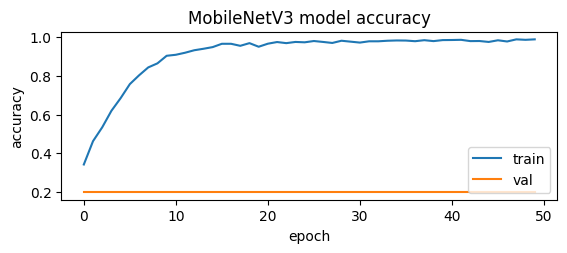

In [ ]:
plt.subplot(2,1,1)
plt.plot(history_mobilenetv3.history['accuracy'])
plt.plot(history_mobilenetv3.history['val_accuracy'])
plt.title('MobileNetV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: MobileNetV3</h2>

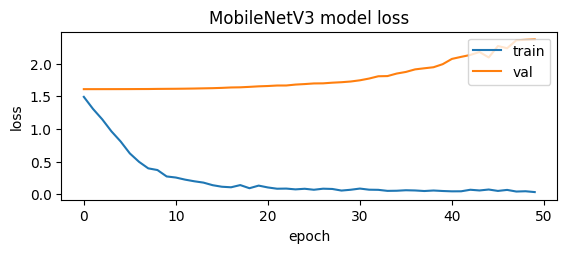

In [ ]:
plt.subplot(2,1,2)
plt.plot(history_mobilenetv3.history['loss'])
plt.plot(history_mobilenetv3.history['val_loss'])
plt.title('MobileNetV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

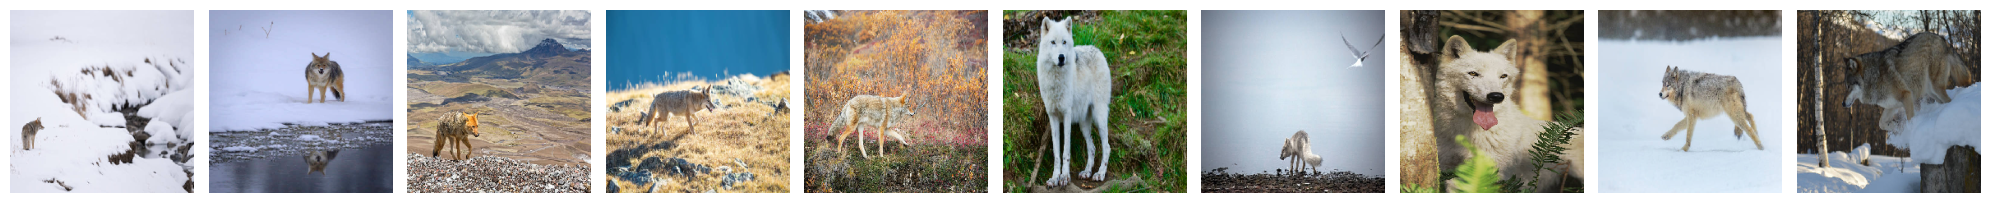

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [ ]:
test_imgs_mobilenetv3, test_labels_mobilenetv3 = next(test_batches_mobilenetv3)
plotImages(test_imgs_mobilenetv3)
print(test_labels_mobilenetv3)

In [ ]:
test_batches_mobilenetv3.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], d

In [ ]:
predictions_mobilenetv3 = mobilenetv3_model.predict(x=test_batches_mobilenetv3, verbose=0)

In [ ]:
np.round(predictions_mobilenetv3)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
cm_mobilenetv3 = confusion_matrix(y_true=test_batches_mobilenetv3.classes, y_pred=np.argmax(predictions_mobilenetv3, axis=-1))

In [ ]:
test_batches_mobilenetv3.class_indices

{'tundra-wolf': 0,
 'domestic-dog': 1,
 'italian-wolf': 2,
 'arctic-wolf': 3,
 'red-wolf': 4}

Confusion matrix, without normalization
[[60  0  0  0  0]
 [60  0  0  0  0]
 [60  0  0  0  0]
 [60  0  0  0  0]
 [60  0  0  0  0]]


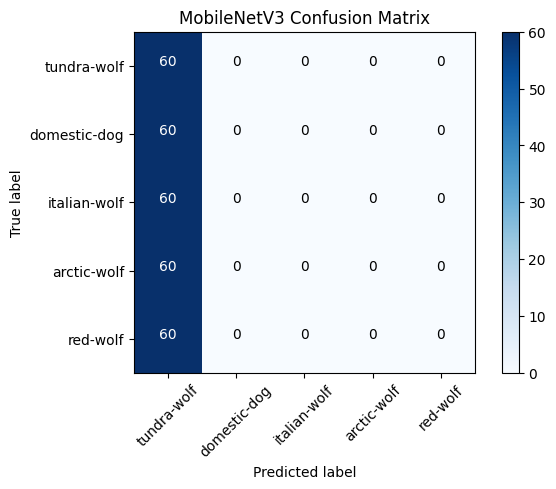

In [ ]:
cm_plot_labels_mobilenetv3 = ['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf']
plot_confusion_matrix(cm=cm_mobilenetv3, classes=cm_plot_labels_mobilenetv3, title='MobileNetV3 Confusion Matrix')

In [ ]:
loss_mobilenetv3, acc_mobilenetv3 = mobilenetv3_model.evaluate(test_imgs_mobilenetv3, test_labels_mobilenetv3, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8750 - loss: 0.6535


In [ ]:
print("Training time using MobileNetV3 model: " + str(training_time_mobilenetv3/60) + "minutes")

Training time using MobileNetV3 model: 17.284673961003623minutes


In [5]:
# Confusion matrix
confusion_matrix = np.array([
    [60, 0, 0, 0, 0],
    [60, 0, 0, 0, 0],
    [60, 0, 0, 0, 0],
    [60, 0, 0, 0, 0],
    [60, 0, 0, 0, 0]
])

# Number of classes
num_classes = confusion_matrix.shape[0]

# Initialize lists to store precision, recall, and AP for each class
precision = []
recall = []
average_precision = []

# Calculate precision, recall, and AP for each class
for i in range(num_classes):
    TP = confusion_matrix[i, i]  # True Positives
    FP = np.sum(confusion_matrix[:, i]) - TP  # False Positives
    FN = np.sum(confusion_matrix[i, :]) - TP  # False Negatives

    # Precision and Recall
    if TP + FP > 0:
        precision_i = TP / (TP + FP)
    else:
        precision_i = 0  # Avoid division by zero

    if TP + FN > 0:
        recall_i = TP / (TP + FN)
    else:
        recall_i = 0  # Avoid division by zero

    precision.append(precision_i)
    recall.append(recall_i)

    # Average Precision (AP)
    if recall_i > 0:
        ap_i = precision_i  # For this case, AP is equal to precision
    else:
        ap_i = 0

    average_precision.append(ap_i)

# Mean Average Precision (mAP)
mAP = np.mean(average_precision)

# Print results
print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("Average Precision (AP) for each class:", average_precision)
print("Mean Average Precision (mAP):", mAP)

Precision for each class: [0.2, 0, 0, 0, 0]
Recall for each class: [1.0, 0.0, 0.0, 0.0, 0.0]
Average Precision (AP) for each class: [0.2, 0, 0, 0, 0]
Mean Average Precision (mAP): 0.04


# Conclusion

Based on the conclusion, **DenseNet121** is the best model suited for this classification task. The reason is because:




*   **Accuracy**: DenseNet121 and MobileNetV3 has the same accuracy of 87.5% which is these two models is higher than ResNet50 at 75%.

*   **Loss**: DenseNet121 has the lowest loss rate which is at 29.7% compare to the MobileNetV3 at 65.3% and ResNet50 at 93.1%

*   **mAP**: DenseNet has the highest mean Average Precision (mAP) at 68% compare to ResNet50 at 63% and MobileNetV3 at 4%

*   **Training Time**: Although DenseNet121 takes a longest training time which is 32.15 minutes compare to the MobileNetV3 at 17.28 minutes and ResNet50 at 28.5 minutes. This indicate that the performance in terms of accuracy, loss, and mAP justifies the extra traning time.

*   **Parametes**: While DenseNet121 has more parameters than MobileNetV3, it balances model complexity and performance better than ResNet50


Based on this explaination in terms of model’s parameter, accuracy, mAP, and training time, DenseNet121 is the best model suited for this classification task.




